In [2]:
!pip install rasterio

  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 31.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Using cached click-8.3.1-py3-none-any.whl (108 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [rasterio]━━ 3/4 [rasterio]


In [7]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.4 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 41.6 MB/s eta 0:00:00m eta 0:00:010:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]


In [10]:
!pip install scikit-image

  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 35.7 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-image]0m 4/5 [scikit-image]


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import rasterio as rio

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist

from PIL import Image



In [ ]:
images_dir ='../data/images'
masks_dir = '../data/masks'

images = sorted(os.listdir(images_dir))
masks = sorted(os.listdir(masks_dir))
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


Number of images: 203
Number of masks: 203


In [14]:
train_images=np.array(train_images)
train_masks=np.array(train_masks)
val_images=np.array(val_images)
val_masks=np.array(val_masks)

Image shape: (420, 420, 3)
Mask shape: (420, 420, 3)


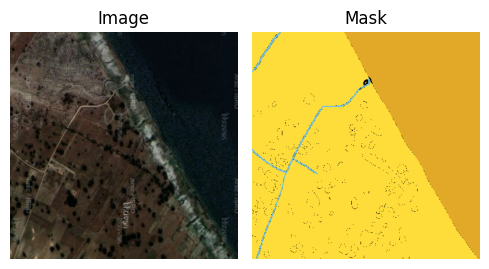

Image shape: (2546, 1903, 3)
Mask shape: (2546, 1903, 3)


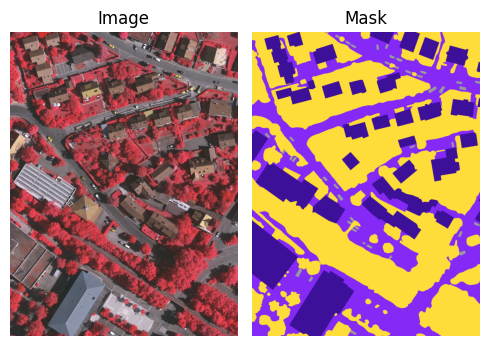

Image shape: (420, 420, 3)
Mask shape: (420, 420, 3)


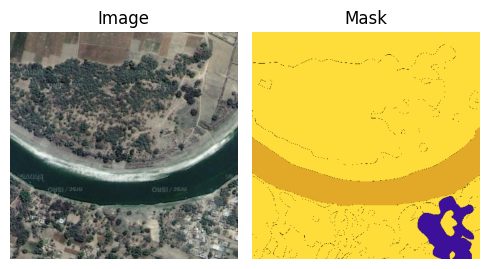

Image shape: (2546, 1903, 3)
Mask shape: (2546, 1903, 3)


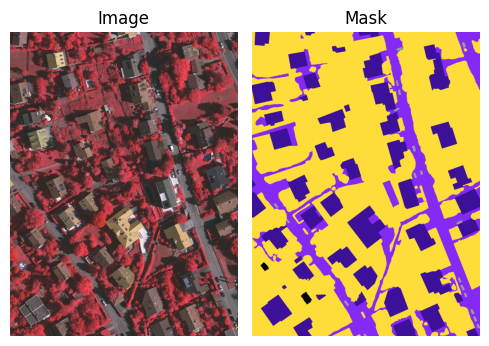

Image shape: (6000, 6000, 3)
Mask shape: (6000, 6000, 3)


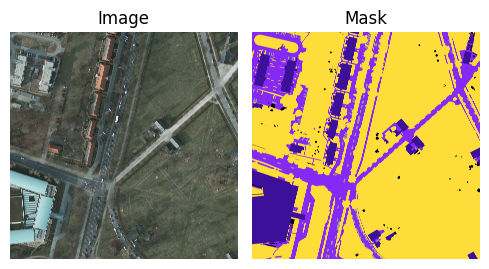

In [15]:
#fig, axes=plt.subplots(2,5,figsize=(10,10))
#axes=axes.ravel()

def plot_image_mask_pair(image, mask, title_img="Image", title_mask="Mask"):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5)) # Create 1 row, 2 columns
    axes=axes.ravel()
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title(title_img)
    axes[0].axis('off') # Hide axes ticks

    # Plot the mask (often single channel, use a colormap)
    # Use cmap='gray' or 'viridis', 'jet' for different looks
    axes[1].imshow(mask) # For binary/single-class masks
    # axes[1].imshow(mask, cmap='viridis', vmin=0, vmax=2) # For multi-class (e.g., 3 classes)
    axes[1].set_title(title_mask)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

for i in np.arange(0, 5):
    idx=np.random.randint(0, len(train_images))
    image_data=plt.imread(os.path.join(images_dir, train_images[idx]))
    masks_data=plt.imread(os.path.join(masks_dir, train_masks[idx]))
    plot_image_mask_pair(image_data, masks_data)



/home/jyoti/miniconda3/envs/my_jupyter_env/lib/python3.13/site-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


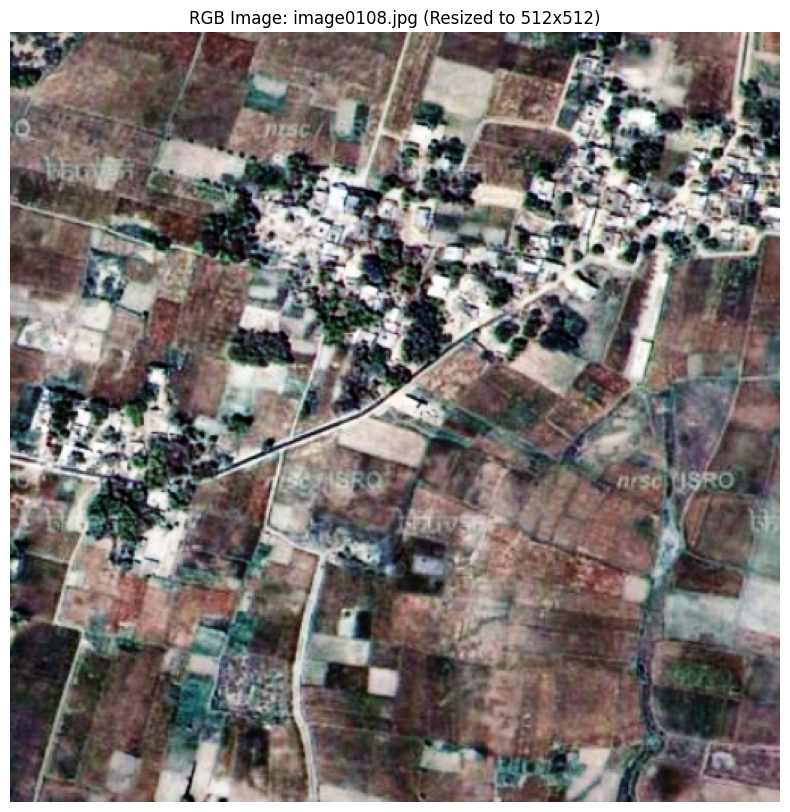

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio as rio
from skimage.exposure import equalize_adapthist
from PIL import Image # For resizing

def show_rgb_image(bands_list, red=1, green=2, blue=3, target_size=(512, 512)):
  # The original function design expected bands_list to be a list of *band files* for a single image,
  # or a single multi-band file name.
  # However, it was called with 'train_images', which is a list of *many* RGB image filenames.
  # This modification assumes the intent is to show *one* representative RGB image from the list,
  # and apply histogram equalization, ensuring a consistent output size.

  if len(bands_list) == 0:
    print("bands_list is empty, cannot display image.")
    return

  # Select a single random image from the provided list of image filenames
  selected_image_filename = np.random.choice(bands_list)
  image_path = os.path.join(images_dir, selected_image_filename)

  try:
    # Open the image using rasterio to read individual bands and resize
    with rio.open(image_path) as src:
        # Read the desired bands. For standard JPGs, these are typically 1, 2, 3
        # Adjusting the default red, green, blue indices to 1, 2, 3 for common RGB images
        # Ensure 'red', 'green', 'blue' are valid band indices for the opened image
        num_bands = src.count
        current_red = min(red, num_bands)
        current_green = min(green, num_bands)
        current_blue = min(blue, num_bands)

        # Read bands and resize them individually using rasterio's out_shape parameter
        red_band_data = src.read(current_red, out_shape=target_size, resampling=rio.enums.Resampling.bilinear)
        green_band_data = src.read(current_green, out_shape=target_size, resampling=rio.enums.Resampling.bilinear)
        blue_band_data = src.read(current_blue, out_shape=target_size, resampling=rio.enums.Resampling.bilinear)

        # Stack the bands to form an RGB image
        rgb_image_stacked = np.stack([red_band_data, green_band_data, blue_band_data], axis=2)

        # Apply histogram equalization to each channel
        for i in range(3):
            # Ensure data type is float before equalization if not already (skimage expects float)
            if rgb_image_stacked[:,:,i].dtype == np.uint8:
                # Normalize to 0-1 range for equalize_adapthist, then scale back
                rgb_image_stacked[:,:,i] = equalize_adapthist(rgb_image_stacked[:,:,i] / 255.0) * 255
            else:
                rgb_image_stacked[:,:,i] = equalize_adapthist(rgb_image_stacked[:,:,i])

        # Clamp values to 0-255 and convert to uint8 for display if necessary
        rgb_image_stacked = np.clip(rgb_image_stacked, 0, 255).astype(np.uint8)

        plt.figure(figsize=(10,10))
        plt.axis('off')
        plt.imshow(rgb_image_stacked)
        plt.title(f"RGB Image: {selected_image_filename} (Resized to {target_size[0]}x{target_size[1]})")
        plt.show()

  except Exception as e:
    print(f"Error processing image {selected_image_filename}: {e}")

# Call the modified function with train_images
# Use UNET_TARGET_SIZE for consistency with other transformations in the notebook.
show_rgb_image(train_images)

In [28]:
# check for negative values in training masks
import random
def check_mask_data():
    #Training masks
    for i in np.arange(0, 15):
        idx=np.random.randint(0, len(train_masks))
        mask_data=plt.imread(os.path.join(masks_dir, train_masks[idx]))
        has_negative=np.any(mask_data<0)
        if has_negative:
            print(f"mask[{idx}] has negative values")
            negative_indices=np.where(mask_data<0)
            print(f"Indices of negative values:{negative_indices}")
        else:
             print(f"Train mask[{idx}] does not have negative values")
    # validation masks        
    for i in np.arange(0, 5):
        idx=np.random.randint(0, len(val_masks))
        mask_data=plt.imread(os.path.join(masks_dir, val_masks[idx]))
        has_negative=np.any(mask_data<0)
        if has_negative:
            print(f"mask[{idx}] has negative values")
            negative_indices=np.where(mask_data<0)
            print(f"Indices of negative values:{negative_indices}")
        else:
            print(f"Validation mask[{idx}] does not have negative values")
check_mask_data()

Train mask[151] does not have negative values
Train mask[103] does not have negative values
Train mask[102] does not have negative values
Train mask[158] does not have negative values
Train mask[12] does not have negative values
Train mask[74] does not have negative values
Train mask[44] does not have negative values
Train mask[126] does not have negative values
Train mask[28] does not have negative values
Train mask[120] does not have negative values
Train mask[153] does not have negative values
Train mask[76] does not have negative values
Train mask[4] does not have negative values
Train mask[51] does not have negative values
Train mask[50] does not have negative values
Validation mask[4] does not have negative values
Validation mask[40] does not have negative values
Validation mask[28] does not have negative values
Validation mask[21] does not have negative values
Validation mask[20] does not have negative values


In [29]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  '#FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = '#E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [30]:
#Generate class label map
#Building: #3C1098
#Land (unpaved area): #8429F6
#Road: #6EC1E4
#Vegetation: #FEDD3A
#Water: #E2A929
#Unlabeled: #9B9B9B
#Object
color_map = {
    (60, 16, 152):0,   # Building #Dark voilet
    (132, 41, 246):1,  # Land (unpaved area) # Bright voilet
    (110, 193, 228):2, # Road # soft blue
    (254, 221, 58):3,  # Vegetation # Bright yellow
    (226, 169, 41):4,  # Water # Bright orange
    (155, 155, 155):5  # Object # Dark Gray
}



In [25]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    # print(f"DEBUG: Inside rgb_to_2D_label. Input label type: {type(label)}, shape: {label.shape}, dtype: {label.dtype}")

    # Ensure label is a numpy array and has 3 channels (HxWx3)
    if not isinstance(label, np.ndarray) or label.ndim != 3 or label.shape[2] != 3:
        # Removed: print(f"WARNING: Input label to rgb_to_2D_label does not have expected HxWx3 shape. Got {label.shape}")
        raise ValueError(f"Input to rgb_to_2D_label must be an HxWx3 numpy array, but got shape {label.shape}")

    height, width, _ = label.shape
    label_seg = np.zeros((height, width), dtype=np.uint8) # Initialize as a 2D array (HxW)

    # print(f"DEBUG: Type of Building: {type(Building)}, Land: {type(Land)}, Road: {type(Road)}, Vegetation: {type(Vegetation)}, Water: {type(Water)}, Unlabeled: {type(Unlabeled)}")
    # print(f"DEBUG: Building value: {Building}, type: {type(Building)}, dtype: {Building.dtype}")
    # print(f"DEBUG: Land value: {Land}, type: {type(Land)}, dtype: {Land.dtype}")
    # print(f"DEBUG: Road value: {Road}, type: {type(Road)}, dtype: {Road.dtype}")
    # print(f"DEBUG: Vegetation value: {Vegetation}, type: {type(Vegetation)}, dtype: {Vegetation.dtype}")
    # print(f"DEBUG: Water value: {Water}, type: {type(Water)}, dtype: {Water.dtype}")
    # print(f"DEBUG: Unlabeled value: {Unlabeled}, type: {type(Unlabeled)}, dtype: {Unlabeled.dtype}")

    try:
        label_seg[np.all(label == Building, axis=-1)] = 0
    except Exception as e:
        print(f"ERROR: Failed at Building comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Land, axis=-1)] = 1
    except Exception as e:
        print(f"ERROR: Failed at Land comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Road, axis=-1)] = 2
    except Exception as e:
        print(f"ERROR: Failed at Road comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Vegetation, axis=-1)] = 3
    except Exception as e:
        print(f"ERROR: Failed at Vegetation comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Water, axis=-1)] = 4
    except Exception as e:
        print(f"ERROR: Failed at Water comparison: {e}")
        raise

    try:
        label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    except Exception as e:
        print(f"ERROR: Failed at Unlabeled comparison: {e}")
        raise

    return label_seg

In [26]:
# Application of color maps
def apply_color_map(mask, color_map):
    # Ensure mask is a numpy array (it should be (H, W) with integer class labels)
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # The mask is now (H, W), so unpack only height and width
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # The input color_map maps RGB_tuple -> integer_label.
    # We need to reverse this to map integer_label -> RGB_tuple for easier lookup.
    label_to_rgb = {v: k for k, v in color_map.items()}


    # Create a lookup table (palette) for colors.
    # Assuming labels are 0-indexed and contiguous up to max_label.
    # If labels are sparse, max_label + 1 needs to be adjusted or handle missing labels.
    max_label = max(label_to_rgb.keys())
    palette = np.zeros((max_label + 1, 3), dtype=np.uint8)
    for label_int, rgb_tuple in label_to_rgb.items():
        palette[label_int] = list(rgb_tuple) # Assign RGB values to palette rows

    # Use the mask values as indices into the palette to get the colored image
    # mask is (H,W), palette is (num_classes, 3)
    # The result `colored_mask` will be (H,W,3)
    colored_mask = palette[mask]

    return colored_mask